<img align="left" src=https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=200 style="padding: 10px">
<br>
<b>AuxTel LATISS V&V Analysis Notebook</b> <br>
Contact author: Meredith Rawls<br>
Last verified to run: March 13, 2024<br>
LSST Science Piplines version: w_2024_10<br>
Container Size: Large <br>

# PREOPS-4964: Follow-up investigation of diaSource lines in Auxtel

Goal: While PREOPS-3603 figured out that many of the bogus vertial lines have pixel flags attached to them for easy filtering out, this is not always the case. Figure out what is causing this so we can eliminate these sources.

Along the way, look at ComCamSim diaSources too, because why not.

**Main takeaways:**

The LATISS diaSource vertical lines originate at amp boundaries that are not masked and probably should be (during ISR, I would guess?).

Calculating how many diaSources we expect from Gaussian noise alone is probably a metric we should implement soon!

I'm not sure why the psfSize (sigma) values are so low for ComCamSim (around 1.2-2.2) but so high for LATISS (around 3.5-10)?

## Table of Contents

1. [Imports and setup](#section_1)
2. [Some simple plots](#section_2)
3. [Subset region for LATISS further investigation](#section_3)
4. [LATISS diaSources on top of a calexp](#section_4)
5. [Side quest: same analysis for diaSources in the ComCamSim ops rehearsal prep repo](#section_5)

## 1. <a id="section_1">Imports and setup</a>

In [1]:
%matplotlib widget

In [291]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import functools
import operator

In [4]:
import lsst.daf.butler as dafButler
from lsst.pex.config import Config
from lsst.pipe.base import Instrument

In [5]:
import lsst.afw.display as afwDisplay
import lsst.display.astrowidgets
afwDisplay.setDefaultBackend('astrowidgets')

In [30]:
repo = '/sdf/group/rubin/repo/embargo'
skymapName = 'latiss_v1'
instrumentName = 'LATISS'
#collectionBig = 'u/huanlin/LATISS/runs/AUXTEL_DRP_IMAGING_2023-09A-08ABC-07AB-05AB/d_2023_09_25/DM-39038'
collectionOld = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20231207/w_2023_49/PREOPS-4648'
collectionNew = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871'
#collectionStr = collections.replace("/", "_")
butlerOld = dafButler.Butler(repo, collections=collectionOld, skymap=skymapName)
butlerNew = dafButler.Butler(repo, collections=collectionNew, skymap=skymapName)

## 2. <a id="section_2">Some simple plots</a>

In [31]:
print(butlerOld.registry.queryDatasets('goodSeeingCoadd').count())
print(butlerNew.registry.queryDatasets('goodSeeingCoadd').count())

441
432


In [32]:
print(butlerOld.registry.queryDatasets('goodSeeingDiff_assocDiaSrcTable').count())
print(butlerNew.registry.queryDatasets('goodSeeingDiff_assocDiaSrcTable').count())

119
118


In [33]:
print(butlerOld.registry.queryDatasets('diaSourceTable').count())
print(butlerNew.registry.queryDatasets('diaSourceTable').count())

2955
3534


In [59]:
visitListOld = []
for item in butlerOld.registry.queryDatasets('diaSourceTable'):
    visitListOld.append(item.dataId.get('visit'))
print(len(set(visitListOld)))
visitListNew = []
for item in butlerNew.registry.queryDatasets('diaSourceTable'):
    visitListNew.append(item.dataId.get('visit'))
print(len(set(visitListNew)))

2955
3534


In [242]:
def multiVisitPlotter(butler, visitList, datasetType='diaSourceTable', badFlagList=None,
                      printBadDiaSourceInfo=False):
    """Plot DiaSources from multiple visits.
    """
    for visit in visitList:
        try:
            oneDiaSourceTable = butler.get(datasetType, visit=visit)
        except LookupError:
            print(f'There is no visit {visit}, skipping it')
            continue
        else:
            # Deal with schema changes
            if 'filterName' in oneDiaSourceTable.columns:
                filterColumnName = 'filterName'
            else:
                filterColumnName = 'band'
            if 'decl' in oneDiaSourceTable.columns:
                decColumnName = 'decl'
            else:
                decColumnName = 'dec'

            # Set colors for different bands
            if oneDiaSourceTable.iloc[0][filterColumnName] == 'g':
                color = 'C0'  # blue
            elif oneDiaSourceTable.iloc[0][filterColumnName] == 'r':
                color = 'C1'  # orange
            elif oneDiaSourceTable.iloc[0][filterColumnName] == 'i':
                color = 'C3'  # red
            else:
                color = '0.75'  # gray
            if badFlagList is None:
                plt.scatter(oneDiaSourceTable.ra, oneDiaSourceTable[decColumnName], s=5, color=color, alpha=0.5)
                if printBadDiaSourceInfo:
                    print('Not filtering out any DiaSources; no badDiaSourceInfo to print')
            else:
                # Build up all the bad flags, e.g., (df['badflag1'] | df['badflag2'])
                conditionList = [oneDiaSourceTable[badFlag]==False for badFlag in badFlagList]
                bitwise_or_bad_flags = conditionList[0]
                for condition in conditionList:
                    bitwise_or_bad_flags |= condition
                bitwise_or_bad_flags.name = 'bitwise_or_bad_flags'
                if printBadDiaSourceInfo:
                    print(f'Visit {visit}: Ignoring {bitwise_or_bad_flags.value_counts().values[1]} bad DiaSources ({bitwise_or_bad_flags.value_counts().values[0]} DiaSources remain)')
                plt.scatter(oneDiaSourceTable.loc[bitwise_or_bad_flags, 'ra'],
                            oneDiaSourceTable.loc[bitwise_or_bad_flags, decColumnName],
                            s=5, color=color, alpha=0.5)
            plt.xlabel('RA (deg)')
            plt.ylabel('Dec (deg)')

In [302]:
badFlagList = ['pixelFlags_bad', 'pixelFlags_interpolatedCenter', 'pixelFlags_interpolated', 'pixelFlags_edge', 'isDipole']

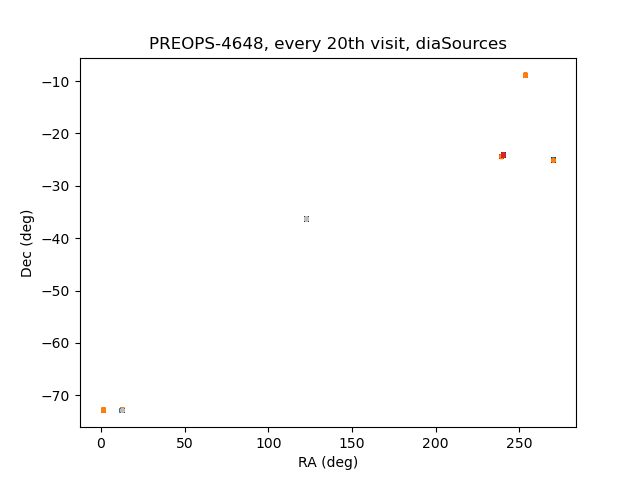

In [252]:
fig = plt.figure()
plt.title('PREOPS-4648, every 20th visit, diaSources')
multiVisitPlotter(butlerOld, visitListOld[::20], badFlagList=badFlagList)

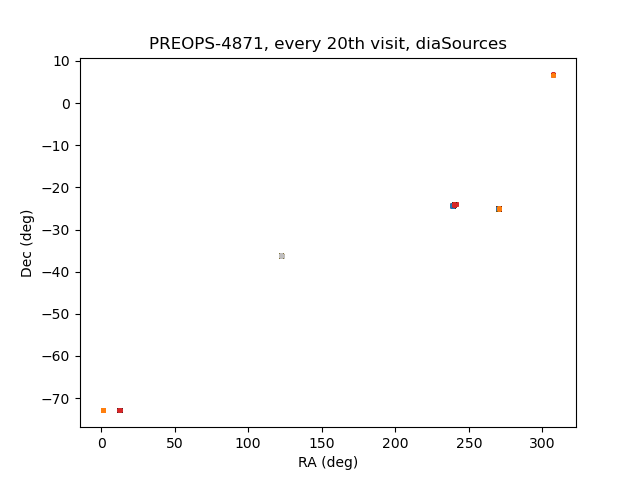

In [388]:
fig = plt.figure()
plt.title('PREOPS-4871, every 20th visit, diaSources')
multiVisitPlotter(butlerNew, visitListNew[::20], badFlagList=badFlagList)

In [389]:
def plotThreeSpatialRegions(butler, collection, visitList, badFlagList=None):
    """Loop over multiVisitPlotter.
    """

    fig = plt.figure(figsize=(9,7))
    fig.suptitle(f'DiaSources from {collection}', fontsize=10)
    
    ax1 = fig.add_subplot(221)
    ax1.set_xlim(239.1, 238.8)
    ax1.set_ylim(-24.425, -24.200)
    multiVisitPlotter(butler, visitList, badFlagList=badFlagList)
    
    ax2 = fig.add_subplot(222)
    ax2.set_xlim(240.15, 239.85)
    ax2.set_ylim(-24.15, -23.85)
    multiVisitPlotter(butler, visitList, badFlagList=badFlagList)
    
    ax3 = fig.add_subplot(223)
    ax3.set_xlim(270.35, 270.05)
    ax3.set_ylim(-25.12, -24.87)
    multiVisitPlotter(butler, visitList, badFlagList=badFlagList)

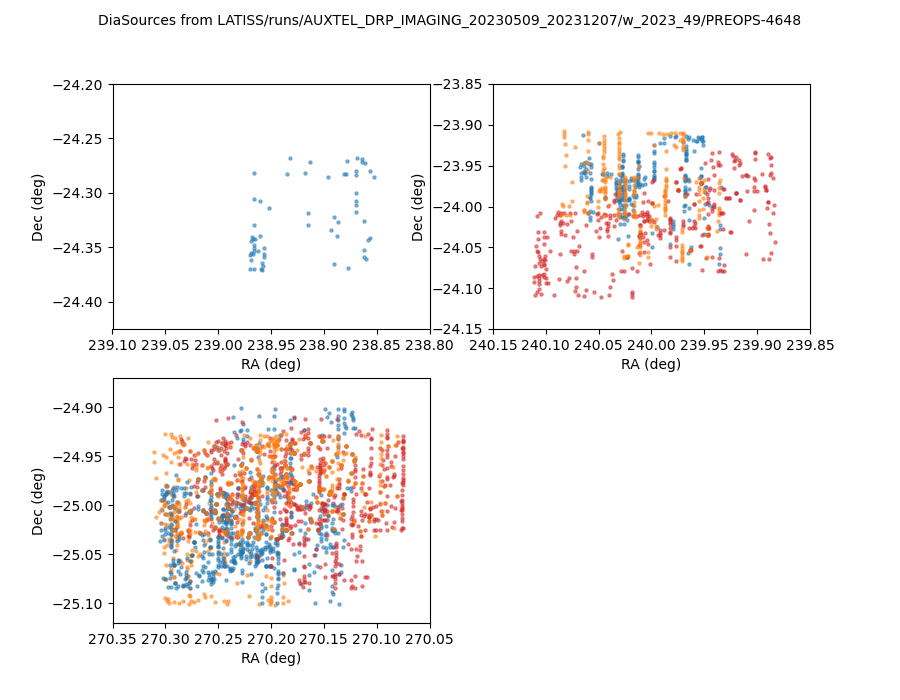

In [387]:
plotThreeSpatialRegions(butlerOld, collectionOld, visitListOld[0:50], badFlagList=badFlagList)

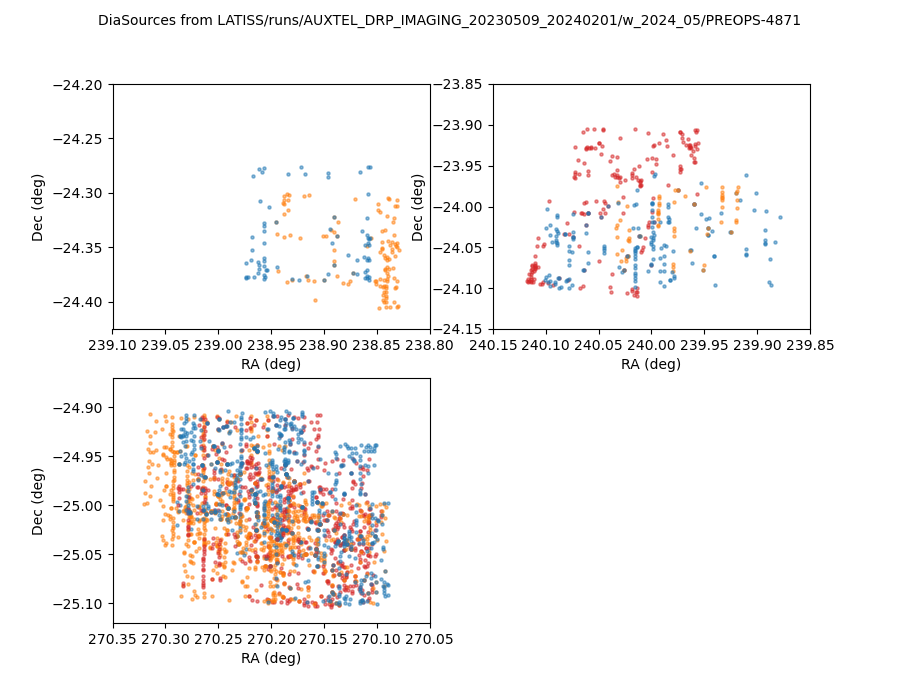

In [386]:
plotThreeSpatialRegions(butlerNew, collectionNew, visitListNew[0:50], badFlagList=badFlagList)

In [67]:
oneDiaSourceTable = butlerNew.get('diaSourceTable', visit=visitListNew[0])

In [68]:
oneDiaSourceTable.columns

Index(['diaSourceId', 'ccdVisitId', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr', 'ixx',
       'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'reliability', 'pixelFlags',
       'pixelFlags_offimage', 'pixelFlags_edge', 'pixelFlags_interpolated',
       'pixelFlags_saturated', 'pixelFlags_cr', 'pixelFlags_bad',
       'pixelFlags_suspect', 'pixelFlags_interpolatedCenter',
       'pixelFlags_saturatedCenter', 'pixelFlags_crCenter',
       'pixelFlags_suspectCenter', 'centroid_flag', 'centroi

## 3. <a id="section_3">Subset region for LATISS further investigation</a>

* RA between (270.35, 270.05)
* Dec between (-25.12, -24.87)

In [108]:
subsetVisitList = []
for visit in visitListNew:
    raMin = 270.05
    raMax = 270.35
    decMin = -25.12
    decMax = -24.87
    bbox = butlerNew.get('calexp.bbox', visit=visit, detector=0)
    wcs = butlerNew.get('calexp.wcs', visit=visit, detector=0)
    raCenter = wcs.pixelToSky(bbox.getCenter()).getRa().asDegrees()
    decCenter = wcs.pixelToSky(bbox.getCenter()).getDec().asDegrees()
    if (raCenter > raMin) and (raCenter < raMax) and (decCenter > decMin) and (decCenter < decMax):
        subsetVisitList.append(visit)

In [116]:
print(len(subsetVisitList))

1016


In [385]:
# this is SLOW because it plots LOTS of visits
#plt.figure(figsize=(10,10))
#multiVisitPlotter(butlerNew, subsetVisitList, badFlagList=badFlagList)

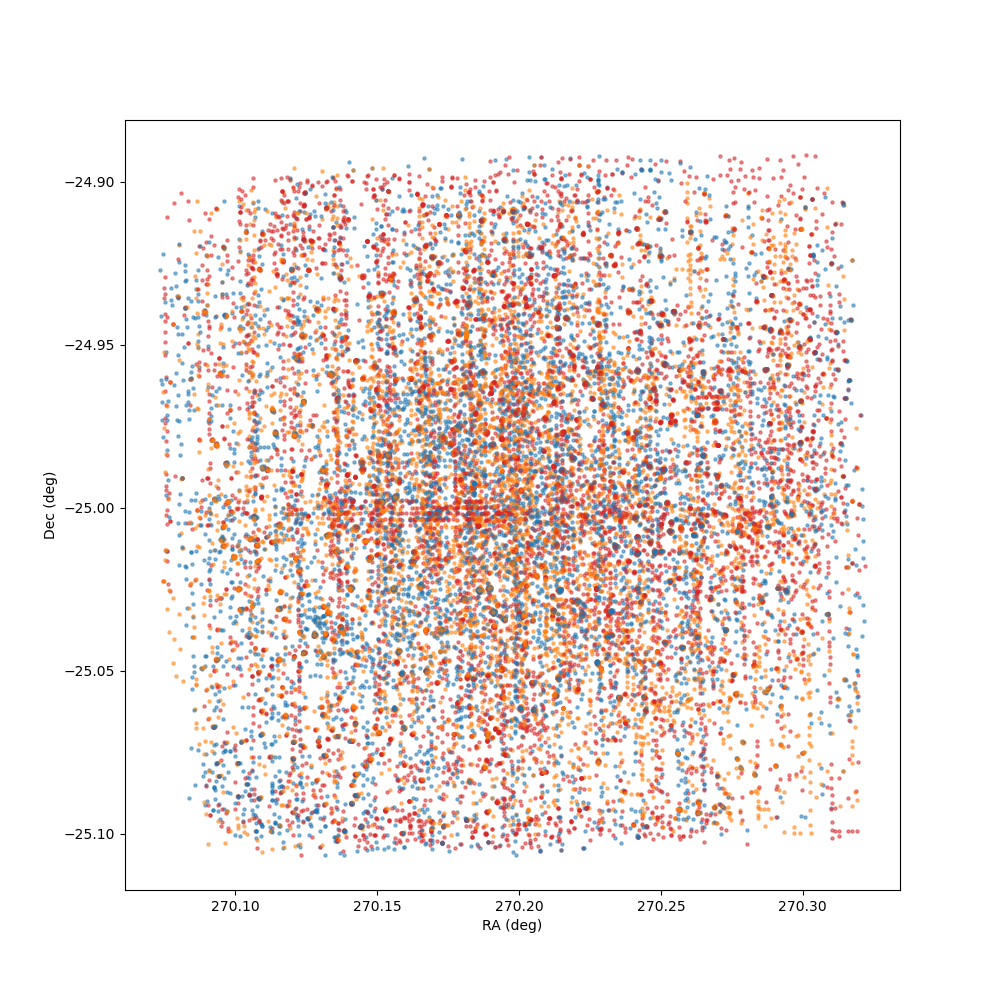

In [384]:
plt.figure(figsize=(10,10))
multiVisitPlotter(butlerNew, subsetVisitList[0:200], badFlagList=badFlagList)

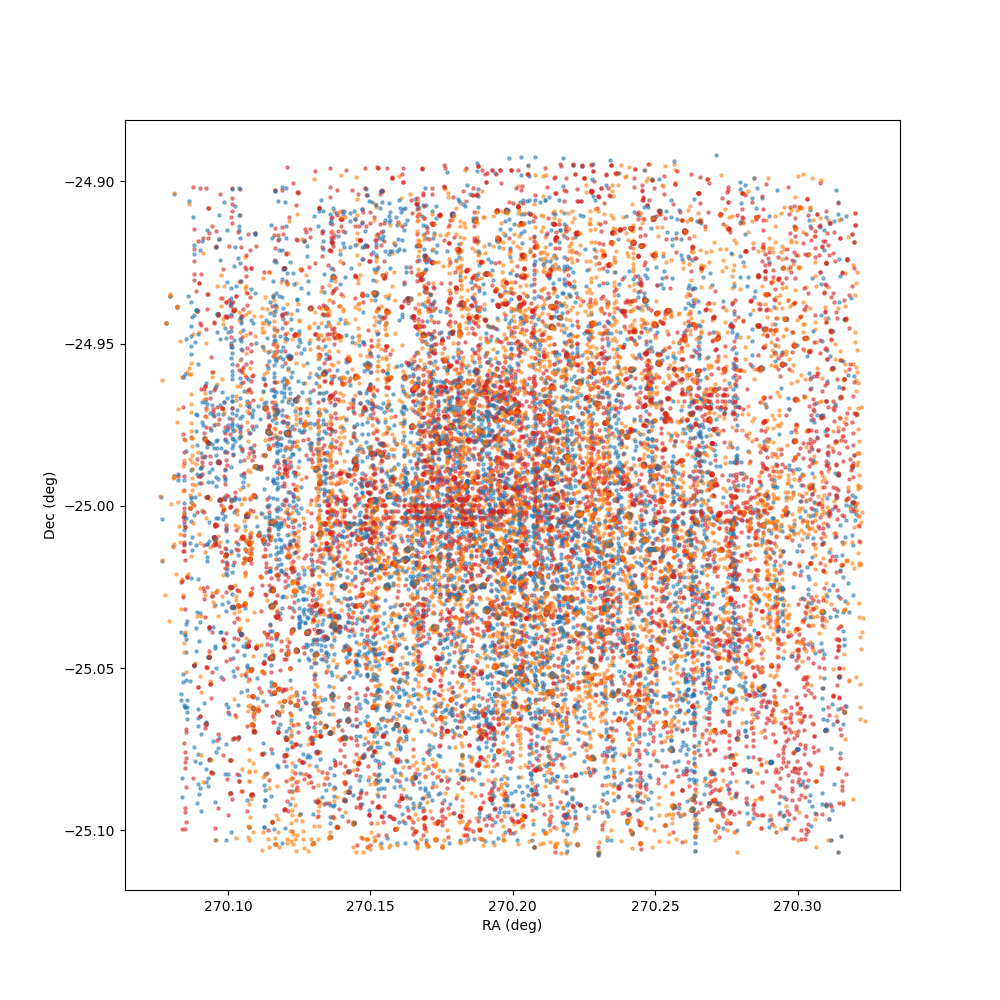

In [383]:
plt.figure(figsize=(10,10))
multiVisitPlotter(butlerNew, subsetVisitList[200:400], badFlagList=badFlagList)

## 4. <a id="section_4">LATISS diaSources on top of a calexp</a>

In [368]:
testTemplate = butlerNew.get('goodSeeingDiff_templateExp', visit=subsetVisitList[0], detector=0)
testDiffim = butlerNew.get('goodSeeingDiff_differenceExp', visit=subsetVisitList[0], detector=0)
testCalexp = butlerNew.get('calexp', visit=subsetVisitList[0], detector=0)
testDiaSourceTable = butlerNew.get('diaSourceTable', visit=subsetVisitList[0], detector=0)

In [369]:
#plt.figure()
display1 = afwDisplay.Display(dims=(800,800))
display1.setMaskTransparency(50)
#display1.mtv(testTemplate)
#display1.mtv(testDiffim)
display1.mtv(testCalexp)
for index, row in testDiaSourceTable.iterrows():
    #display.dot('+', row.x, row.y, ctype='blue', size=10)
    if not (row.pixelFlags_bad | row.pixelFlags_suspect | row.pixelFlags_saturatedCenter
            | row.pixelFlags_interpolated | row.pixelFlags_interpolatedCenter | row.pixelFlags_edge):
        display1.dot('+', row.x, row.y, ctype='blue', size=10)
    if (row.pixelFlags_bad | row.pixelFlags_suspect | row.pixelFlags_saturatedCenter
            | row.pixelFlags_interpolated | row.pixelFlags_interpolatedCenter | row.pixelFlags_edge):
        display1.dot('*', row.x, row.y, ctype='red', size=20)
    if (row.shape_flag):
        display1.dot('*', row.x, row.y, ctype='green', size=20)
    if (row.isDipole):
        display1.dot('*', row.x, row.y, ctype='cyan', size=20)
display1.embed()


ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

In [149]:
testDiaSourceTable.columns

Index(['diaSourceId', 'ccdVisitId', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr', 'ixx',
       'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'reliability', 'pixelFlags',
       'pixelFlags_offimage', 'pixelFlags_edge', 'pixelFlags_interpolated',
       'pixelFlags_saturated', 'pixelFlags_cr', 'pixelFlags_bad',
       'pixelFlags_suspect', 'pixelFlags_interpolatedCenter',
       'pixelFlags_saturatedCenter', 'pixelFlags_crCenter',
       'pixelFlags_suspectCenter', 'centroid_flag', 'centroi

In [153]:
testDiaSourceTable[['ra', 'dec', 'bboxSize', 'scienceFlux', 'scienceFluxErr', 'reliability', 'isDipole']]

ra        dec  bboxSize   scienceFlux  scienceFluxErr  \
0    270.233692 -25.011844       169  2.482394e+07    33948.217365   
1    270.213103 -25.011228        96  3.028012e+06    12225.432860   
2    270.246115 -25.010403        82  3.471688e+06    12943.958720   
3    270.297111 -25.009563        45  1.028783e+06     9107.046900   
4    270.280214 -25.008244        60  3.481506e+04     6902.583923   
..          ...        ...       ...           ...             ...   
169  270.233546 -24.909190       119 -3.806407e+04     6093.622649   
170  270.300692 -24.908282        53  9.563754e+05     7492.817866   
171  270.263585 -24.908159        50  4.809875e+04     6120.286674   
172  270.203666 -24.908813        41 -9.123620e+03     6103.377656   
173  270.314533 -24.907026       105  1.888689e+06     7817.447590   

     reliability  isDipole  
0            NaN     False  
1            NaN     False  
2            NaN     False  
3            NaN     False  
4            NaN     False  
..           ...       ...  
169          NaN     False  
170          NaN     False  
171          NaN     False  
172          NaN     False  
173          NaN     False  

[174 rows x 7 columns]

In [154]:
def diaFlagHist(df, badFlagList=['pixelFlags_edge', 'pixelFlags_bad', 'pixelFlags_suspect',
       'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter', ]):
    """Plot a histogram of all the flag columns from a goodSeeingDiff_assocDiaSrcTable.
    """
    # manually defining a "flag table" as a subset of the full df, sorry
    flagTable = df[['pixelFlags_offimage',
           'pixelFlags_edge', 'pixelFlags_interpolated', 'pixelFlags_saturated',
           'pixelFlags_cr', 'pixelFlags_bad', 'pixelFlags_suspect',
           'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter',
           'pixelFlags_crCenter', 'pixelFlags_suspectCenter', 'centroid_flag',
           'centroid_pos_flag', 'centroid_neg_flag', 'apFlux_flag',
           'apFlux_flag_apertureTruncated', 'psfFlux_flag',
           'psfFlux_flag_noGoodPixels', 'psfFlux_flag_edge', 'forced_PsfFlux_flag',
           'forced_PsfFlux_flag_noGoodPixels', 'forced_PsfFlux_flag_edge',
           'shape_flag', 'shape_flag_no_pixels', 'shape_flag_not_contained',
           'shape_flag_parent_source', 'ext_trailedSources_Naive_flag_edge',]]
    flagSum = flagTable.sum()
    flagsToPlot = [count for count in flagSum.values]
    
    # plot flags in blue unless they are in badFlagList, then use red
    flagColors = []
    for label in flagTable.columns:
        if label in badFlagList:
            flagColors.append('C3')
        else:
            flagColors.append('C0')
    
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.barh(flagTable.columns, flagsToPlot, color=flagColors)
    fig.subplots_adjust(left=0.35)
    ax.set_xlabel('Number of flagged DiaSources')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

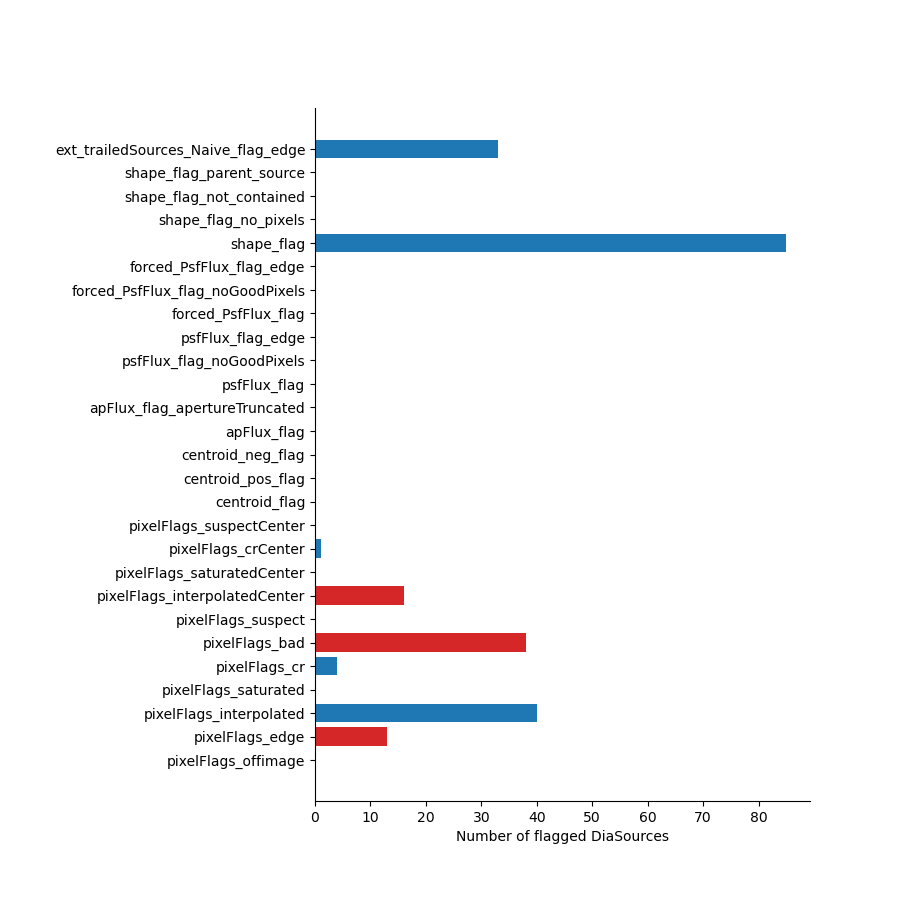

In [382]:
diaFlagHist(testDiaSourceTable)

In [169]:
testWcs = testCalexp.getWcs()

In [172]:
testBBox = testCalexp.getBBox()

In [74]:
oneCalexp = butlerNew.get('calexp', visit=visitListNew[0], detector=0)

In [81]:
oneCalexp.getBBox().getCenter()

Point2D(2035.5, 1999.5)

In [107]:
oneCalexp.wcs.pixelToSky(oneCalexp.getBBox().getCenter()).getRa().asDegrees()

12.525804821644865

In [99]:
oneCalexp.wcs.pixelToSky(oneCalexp.getBBox().getCenter()).getDec()

Angle(-72.769103960378544, degrees)

## 5. <a id="section_5">Side quest: same analysis for diaSources in the ComCamSim ops rehearsal prep repo</a>

We'll basically repeat the steps above for this dataset too

In [192]:
repoSim = '/sdf/group/rubin/repo/ops-rehearsal-3-prep'
skymapNameSim = 'DC2'
instrumentNameSim = 'LSSTComCamSim'
collectionSim = 'u/homer/htc-test1'
butlerSim = dafButler.Butler(repoSim, collections=collectionSim, skymap=skymapNameSim)

In [194]:
print(butlerSim.registry.queryDatasets('goodSeeingCoadd').count())
print(butlerSim.registry.queryDatasets('goodSeeingDiff_assocDiaSrcTable').count())
print(butlerSim.registry.queryDatasets('diaSourceTable').count())

1007
331
2882


In [195]:
visitListSim = []
for item in butlerSim.registry.queryDatasets('diaSourceTable'):
    visitListSim.append(item.dataId.get('visit'))
print(len(set(visitListSim)))

2882


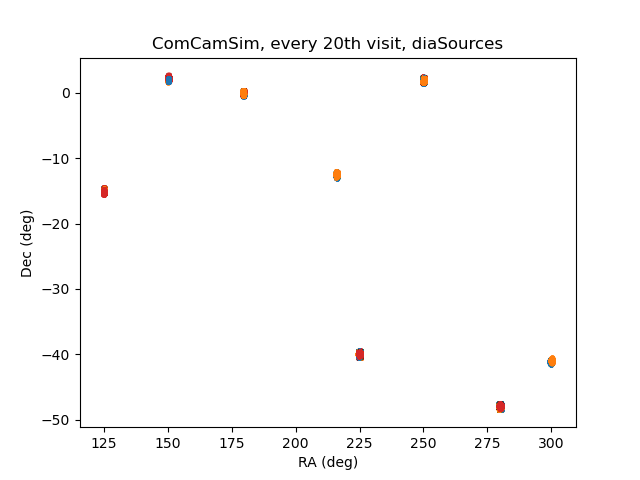

In [245]:
fig = plt.figure()
plt.title('ComCamSim, every 20th visit, diaSources')
multiVisitPlotter(butlerSim, visitListSim[::20])

Spatial region we will use for further investigation

* RA between (249.3, 250.6)
* Dec between (1.35, 2.55)

In [210]:
subsetVisitListSim = []
for visit in visitListSim:
    raMin = 249.3
    raMax = 250.6
    decMin = 1.35
    decMax = 2.55
    bbox = butlerSim.get('calexp.bbox', visit=visit, detector=0)
    wcs = butlerSim.get('calexp.wcs', visit=visit, detector=0)
    raCenter = wcs.pixelToSky(bbox.getCenter()).getRa().asDegrees()
    decCenter = wcs.pixelToSky(bbox.getCenter()).getDec().asDegrees()
    if (raCenter > raMin) and (raCenter < raMax) and (decCenter > decMin) and (decCenter < decMax):
        subsetVisitListSim.append(visit)

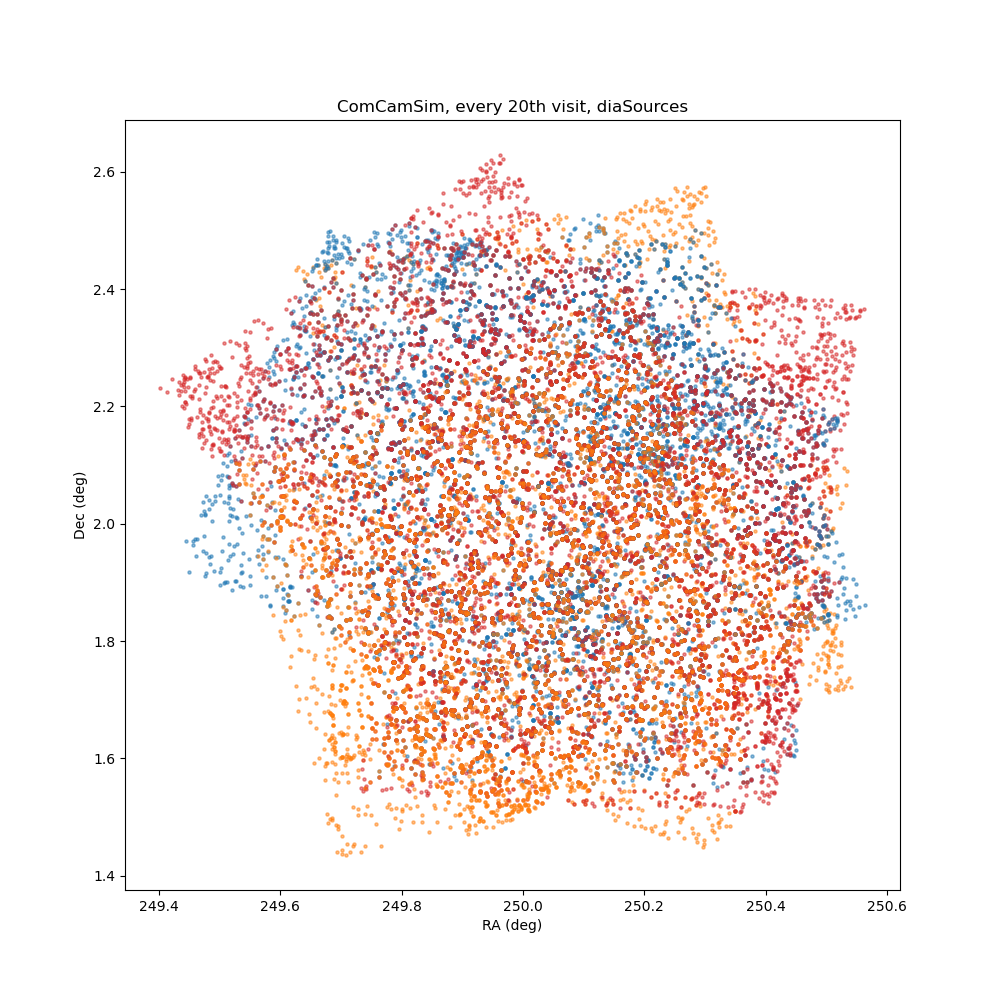

In [390]:
fig = plt.figure(figsize=(10,10))
plt.title('ComCamSim, every 20th visit, diaSources')
multiVisitPlotter(butlerSim, subsetVisitListSim[::20])

In [215]:
testDiaSourceTableSim = butlerSim.get('diaSourceTable', visit=subsetVisitListSim[0])

In [228]:
testDiaSourceTableSim.columns

Index(['diaSourceId', 'ccdVisitId', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr', 'ixx',
       'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'reliability', 'pixelFlags',
       'pixelFlags_offimage', 'pixelFlags_edge', 'pixelFlags_interpolated',
       'pixelFlags_saturated', 'pixelFlags_cr', 'pixelFlags_bad',
       'pixelFlags_suspect', 'pixelFlags_interpolatedCenter',
       'pixelFlags_saturatedCenter', 'pixelFlags_crCenter',
       'pixelFlags_suspectCenter', 'centroid_flag', 'centroi

In [246]:
testTemplateSim = butlerSim.get('goodSeeingDiff_templateExp', visit=subsetVisitListSim[0], detector=0)
testDiffimSim = butlerSim.get('goodSeeingDiff_differenceExp', visit=subsetVisitListSim[0], detector=0)
testCalexpSim = butlerSim.get('calexp', visit=subsetVisitListSim[0], detector=0)
testDiaSourceTableSim = butlerSim.get('diaSourceTable', visit=subsetVisitListSim[0], detector=0)

In [250]:
display2 = afwDisplay.Display(dims=(800,800))
display2.setMaskTransparency(50)
#display2.mtv(testTemplateSim)
display2.mtv(testDiffimSim)
#display2.mtv(testCalexpSim)
for index, row in testDiaSourceTableSim.iterrows():
    #display.dot('+', row.x, row.y, ctype='blue', size=10)
    if not (row.pixelFlags_bad | row.pixelFlags_suspect | row.pixelFlags_saturatedCenter
            | row.pixelFlags_interpolated | row.pixelFlags_interpolatedCenter | row.pixelFlags_edge):
        display2.dot('+', row.x, row.y, ctype='blue', size=10)
    if (row.pixelFlags_bad | row.pixelFlags_suspect | row.pixelFlags_saturatedCenter
            | row.pixelFlags_interpolated | row.pixelFlags_interpolatedCenter | row.pixelFlags_edge):
        display2.dot('*', row.x, row.y, ctype='red', size=20)
    if (row.shape_flag):
        display2.dot('*', row.x, row.y, ctype='green', size=20)
    if (row.isDipole):
        display2.dot('+', row.x, row.y, ctype='cyan', size=20)
display2.embed()

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

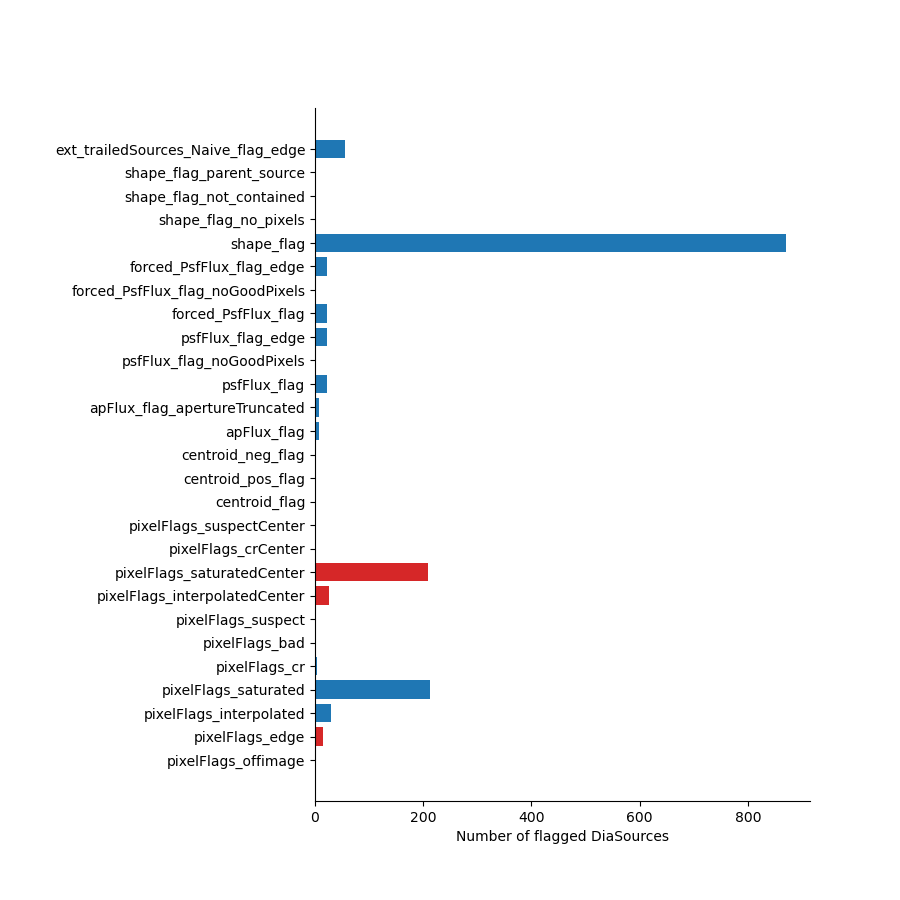

In [401]:
diaFlagHist(testDiaSourceTableSim)

## Plot expected diaSource counts

Most of the bad sources in LATISS aren't flagged, they are on the amp boundaries. In contrast, most of the bad sources in ComCamSim are dipoles. In both cases, recall that the shape flag mostly just catches negative fluxes, which is annoying.

Next, let's use DMTN-006 to estimate expected numbers of diaSources from Gaussian noise alone.  This requires knowing some basic info about each visit/detector so we can accurately calculate diaSources per square degree.

In [394]:
badFlagList = ['pixelFlags_bad', 'pixelFlags_suspect', 'pixelFlags_edge', 'pixelFlags_saturatedCenter',
               'pixelFlags_interpolatedCenter', 'pixelFlags_interpolated', 'pixelFlags_edge', 'isDipole']

In [395]:
#SIGMA2FWHM = 2*np.sqrt(2*np.log(2))  # not currently used

bboxLatiss = butlerNew.get('calexp.bbox', visit=subsetVisitList[0], detector=0)
bboxComcam = butlerSim.get('calexp.bbox', visit=subsetVisitListSim[0], detector=0)

PIXEL_SCALE_COMCAM = butlerSim.get('calexp.wcs', visit=subsetVisitListSim[0], detector=0).getPixelScale().asDegrees()
APPROX_CCD_AREA_COMCAM = PIXEL_SCALE_COMCAM*PIXEL_SCALE_COMCAM*bboxComcam.getArea()
N_CCD_COMCAM = 9
APPROX_VISIT_AREA_COMCAM = APPROX_CCD_AREA_COMCAM * N_CCD_COMCAM
print(f"ComCam visit area is {APPROX_VISIT_AREA_COMCAM} square degrees")

PIXEL_SCALE_LATISS = butlerNew.get('calexp.wcs', visit=subsetVisitList[0], detector=0).getPixelScale().asDegrees()
APPROX_CCD_AREA_LATISS = PIXEL_SCALE_LATISS*PIXEL_SCALE_LATISS*bboxLatiss.getArea()
N_CCD_LATISS = 1
APPROX_VISIT_AREA_LATISS = APPROX_CCD_AREA_LATISS * N_CCD_LATISS
print(f"LATISS visit area is {APPROX_VISIT_AREA_LATISS} square degrees")

ComCam visit area is 0.45292538997164944 square degrees
LATISS visit area is 0.011507291601343367 square degrees


In [396]:
def getPsfSigma(butler, visit, psfDetector=0, badFlagList=None):
    """Count the number of diaSources for a given visit across all detectors, and
    retrieve a representative PSF size (sigma, i.e., seeing proxy) for the visit.
    """
    psfSigma = butler.get("calexp.summaryStats", visit=visit, detector=psfDetector).psfSigma
    oneDiaSourceTable = butler.get("diaSourceTable", visit=visit)  # all detectors
    nDiaSources = len(oneDiaSourceTable)
    if badFlagList:
        badFlags = [oneDiaSourceTable[flag] for flag in badFlagList]
        flagFilter = functools.reduce(operator.or_, badFlags)
        noFlagFilter = ~flagFilter
        nGoodDiaSources = len(oneDiaSourceTable.loc[noFlagFilter])
    else:
        nGoodDiaSources = nDiaSources

    #print(f"PSF sigma is {psfSigma}, there are {nDiaSources} diaSources, and {nGoodDiaSources} good diaSources")
    return psfSigma, nGoodDiaSources

In [360]:
def n(v):
    """For an image with a Gaussian PSF of width sigma in pixels,
    return the density of detections per square degree above a threshold v.
    """
    return v*np.exp(-0.5*v*v)/(2**(5/2) * np.pi**(3/2))

def expectedPerVisit(low, high, seeing, bbox, nDetectors):
    """Compute number of detections expected for one visit.
    Note this calculation uses a PSF size sigma, not FWHM, per DMTN-006.

    Example: for DECam images with seeing (PSF sigma) = 1.8 pixels and a 2k by 4k pixel sensor,
    we expect 1.5 noise detections per sensor at 5 sigma, or 33 detections per square
    degree (twice that if counting both positive and negative detections).
    """
    inBetween = n(low) - n(high)
    
    # Multiply by 2 for positive and negative detections
    # Multiply by the number of detectors and the area of each detector
    
    nCols = bbox.getWidth()
    nRows = bbox.getHeight()
    #print(f"Each detector is {nRows} x {nCols} pixels, and there are {nDetectors} detectors")
    expectedValue = inBetween * 2 * nRows * nCols * nDetectors / (seeing**2)
    
    return expectedValue

In [398]:
def diaSourceCountExpectedPlot(butler, visitList, visitArea, nDetectors, badFlagList):
    """Plot how many diaSources we are measuring per square degree
    alongside a line showing how many we would naively expect
    due to Gaussian noise alone with a 5 sigma detection threshold.
    """
    psfSigmaList = []
    nGoodDiaSources = []
    
    for visit in visitList:
        goodPsfStats = getPsfSigma(butler, visit, psfDetector=0, badFlagList=badFlagList)  # this returns (psfSigma, nGoodDiaSources) for each visit
        psfSigmaList.append(goodPsfStats[0])
        nGoodDiaSources.append(goodPsfStats[1])
    
    #print(f"There are {nVisits} visits")
    psfSigmaRange = np.linspace(np.min(psfSigmaList), np.max(psfSigmaList), 20)
    bbox = butler.get('calexp.bbox', visit=visitList[0], detector=0)
    expectedPerArea = expectedPerVisit(5, 100, psfSigmaRange, bbox, nDetectors) / visitArea
    nGoodDiaSourcesPerArea = [n/visitArea for n in nGoodDiaSources]
    
    plt.figure(figsize=(8,4))
    ax = plt.subplot(111)
    plt.yscale('log')
    plt.ylabel('N diaSources (per sq deg)')
    plt.xlabel('psfSigma (pixels)')
    plt.plot(psfSigmaList, nGoodDiaSourcesPerArea, '.', label="Good diaSources")
    plt.plot(psfSigmaRange, expectedPerArea, label="Expected diaSource count, SNR > 5")
    plt.legend()
    plt.tight_layout()

## Expected diaSource plot for LATISS

We have filtered out diaSources with any of the following flags

```
'pixelFlags_bad', 'pixelFlags_suspect', 'pixelFlags_edge', 'pixelFlags_saturatedCenter',
'pixelFlags_interpolatedCenter', 'pixelFlags_interpolated', 'pixelFlags_edge', 'isDipole'
```

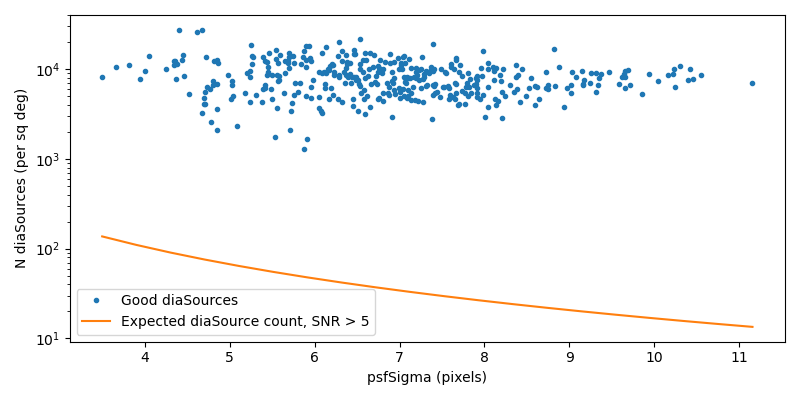

In [399]:
diaSourceCountExpectedPlot(butlerNew, subsetVisitList[0:400], APPROX_VISIT_AREA_LATISS, 1, badFlagList)

## Expected diaSource plot for ComCamSim

As before, we have filtered out diaSources with any of the following flags

```
'pixelFlags_bad', 'pixelFlags_suspect', 'pixelFlags_edge', 'pixelFlags_saturatedCenter',
'pixelFlags_interpolatedCenter', 'pixelFlags_interpolated', 'pixelFlags_edge', 'isDipole'
```

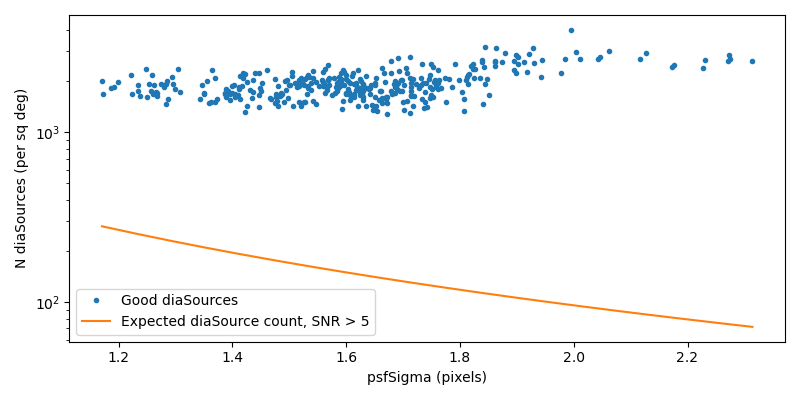

In [400]:
diaSourceCountExpectedPlot(butlerSim, subsetVisitListSim, APPROX_VISIT_AREA_COMCAM, 9, badFlagList)

Reminder of how to retrieve psfSigma from an exposure...! And indeed, the psfSigma values are huge for LATISS but small for ComCamSim

In [380]:
butlerNew.get("calexp.summaryStats", visit=subsetVisitList[0], detector=0)

ExposureSummaryStats(version=0, psfSigma=6.207713357683225, psfArea=625.4557349568673, psfIxx=35.03111417098912, psfIyy=42.39405960874768, psfIxy=-0.3325242399349081, ra=270.2612072370649, dec=-24.95967751513809, zenithDistance=11.002908532027263, zeroPoint=27.90299117545162, skyBg=17.902013078331947, skyNoise=8.398380174233303, meanVar=100.36667410724932, raCorners=[270.202270148233, 270.32168348080165, 270.3200927725878, 270.2007825011925], decCorners=[-25.013530383038752, -25.01212086291655, -24.90580147127488, -24.907209757287486], astromOffsetMean=0.013780654344859916, astromOffsetStd=0.007910052744477578, nPsfStar=159, psfStarDeltaE1Median=-0.0026701418682931674, psfStarDeltaE2Median=-0.008219188079237952, psfStarDeltaE1Scatter=0.022061962816709593, psfStarDeltaE2Scatter=0.02045049345314527, psfStarDeltaSizeMedian=-0.012586142913900034, psfStarDeltaSizeScatter=0.09511113488564642, psfStarScaledDeltaSizeScatter=0.015144496390260978, psfTraceRadiusDelta=0.8139963358067304, maxDistT

In [381]:
butlerSim.get("calexp.summaryStats", visit=subsetVisitListSim[0], detector=0)

ExposureSummaryStats(version=0, psfSigma=1.6297379165171442, psfArea=40.68028867530721, psfIxx=2.7079673452643123, psfIyy=2.605484899819265, psfIxy=0.03145459357191748, ra=249.95276998747318, dec=1.6954131421263188, zenithDistance=31.955130041679418, zeroPoint=31.052148761054518, skyBg=1133.8395206928253, skyNoise=28.970581731442056, meanVar=834.6496175282325, raCorners=[249.8707577758823, 249.81838297880176, 250.03480353634671, 250.0871438759947], decCorners=[1.5596118050800896, 1.779819068174585, 1.83122824762825, 1.6110022716289711], astromOffsetMean=0.005197153003531376, astromOffsetStd=0.003073920330844943, nPsfStar=499, psfStarDeltaE1Median=0.0006469357758762118, psfStarDeltaE2Median=0.0001464819069951647, psfStarDeltaE1Scatter=0.008703027589419005, psfStarDeltaE2Scatter=0.009147829937097458, psfStarDeltaSizeMedian=-0.0002938098416596091, psfStarDeltaSizeScatter=0.008301920113036869, psfStarScaledDeltaSizeScatter=0.005089094612637001, psfTraceRadiusDelta=0.007230271172764313, max